## Solutions to Assignment 4: Exploring Yelp Reviews

**NOTE: THIS ASSIGNMENT IS OPTIONAL**

Your final grade will be based on your highest assignment grades, so this assignment can be used to replace any of your other (lower-graded) assignments. 

**Due date: Friday, 3/15 by 5pm**

In this assignment, we'll explore restaurant review data available through the [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge). The dataset includes Yelp data for user reviews and business information for 10 metropolitan areas. The `data` directory in this repository includes data files for reviews and restaurants in 3 of these cities: Cleveland, Pittsburgh, and Charlotte. These cities were chosen since the data is not too large — the data for the other cities can be downloaded from the Yelp download page. For this assignment, you are welcome to analyze data any of the three cities. 

This assignment is broken into two parts:

#### Part 1: testing how well sentiment analysis works.

Because Yelp reviews include the number of stars given by the user, the Yelp data set provides a unique opportunity to test how well our sentiment analysis works by comparing the number of stars to the polarity of reviews.

#### Part 2: analyzing correlations between restaurant reviews and census data

Analyzing the frequencies of different sets of words in Yelp reviews can offer insight into urban culture. Specifically, we'll test the correlation between household income (using census data) and different types of restaurants, extracted from review data.
    
#### Background readings
- [Does sentiment analysis work?](http://varianceexplained.org/r/yelp-sentiment/)
- [The Geography of Taste: Using Yelp to Study Urban Culture](https://www.mdpi.com/2220-9964/7/9/376/pdf/1)

## 1. Does Sentiment Analysis Work?

In this part, we'll load the data, perform a sentiment analysis, and explore the results.

### 1.1 Load review data

You can choose data from Cleveland, Charlotte, or Pittsburgh. The data is stored as a JSON file and you can use `pandas.read_json` to load it. 

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [1]:
import pandas as pd

In [2]:
reviews = pd.read_json('./data/reviews_pittsburgh.json.gz', orient='records', lines=True)

In [3]:
reviews.head()

,business_id,review_id,stars,text
0,eU_713ec6fTGNO4BegRaww,fdiNeiN_hoCxCMy2wTRW9g,4,I'll be the first to admit that I was not exci...
1,FxLfqxdYPA6Z85PFKaqLrg,Z7wgXp98wYB57QdRY3HQ3w,4,Wow. So surprised at the one and two star revi...
2,9nTF596jDvBBia2EXXiOOg,1daGBpea0sleayFeeXuoYw,1,"if i can give this place no stars i would, i o..."
3,sMzNLdhJZGzYirIWt-fMAg,RLbWoIri29BcQ8yjzsvQLQ,5,This place epitomizes the rumored transformati...
4,hcFSc0OHgZJybnjQBrL_8Q,vAckaF8n0KKJeqHOnb1ayw,4,Here's why I don't write reviews for Chinese r...


### 1.2 Format the review text

The first step is to split the review text into its individual words and make all of the words lower-cased.

Add a new column, called 'formatted_text', which each entry is a list of the lower-cased words in a review.

In [8]:
def split_and_lower(text_string):
    """
    Split a string into individual words and make them 
    all lower case
    """
    return [word.lower() for word in text_string.split()]

In [9]:
reviews['formatted_text'] = reviews['text'].apply(split_and_lower)

### 1.3 Review stop words

Use the `nltk` library to remove any stop words from the list of words in each review. 

Overwrite the 'formatted_text' column to contain a list of lower-cased words in each review, with no stop words. 

In [6]:
from nltk.corpus import stopwords

In [12]:
stop = stopwords.words('english')
print(stop[:5])

['i', 'me', 'my', 'myself', 'we']


In [13]:
def remove_stop_words(list_of_words):
    """
    Keep only words that are not in the list of 
    stop words
    """
    return [word for word in list_of_words if word not in stop]

In [14]:
reviews['formatted_text'] = reviews['formatted_text'].apply(remove_stop_words)

### 1.4 Calculate polarity and subjectivity

Using the formatted text column, create a list of `textblob.TextBlob()` objects and then extract the `subjectivity` and `polarity`.

Add two new columns to the review DataFrame: `polarity` and `subjectivity`.

In [15]:
import textblob

In [17]:
def create_textblob(list_of_words):
    """
    From the list of words, create a TextBlob object.
    
    Note that the TextBlob() object needs a single string, so 
    we must first join the list of words together.
    """
    text_string = " ".join(list_of_words)
    return textblob.TextBlob(text_string)

In [18]:
blobs = reviews['formatted_text'].apply(create_textblob)

In [19]:
# create polarity and subjectivity columns
reviews['polarity'] = [b.polarity for b in blobs]
reviews['subjectivity'] = [b.subjectivity for b in blobs]

### 1.5 Comparing the sentiment analysis to number of stars 

Use `seaborn` to make two box plots, one showing the polarity vs number of user stars and one showing the subjectivity vs the number of user stars.

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

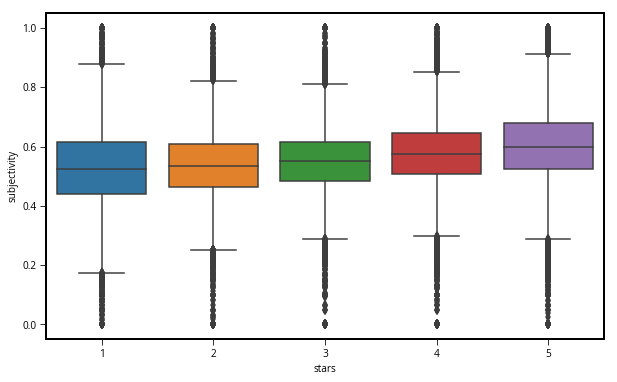

In [21]:
ax = sns.boxplot(x="stars", y="subjectivity", data=reviews)
ax.figure.set_size_inches((10,6))

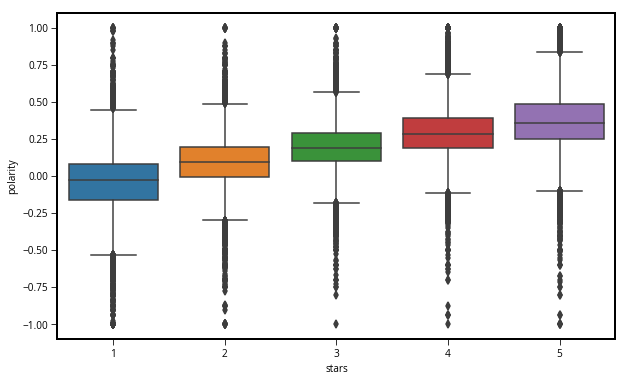

In [22]:
ax = sns.boxplot(x="stars", y="polarity", data=reviews)
ax.figure.set_size_inches((10,6))

**Question:** What do your charts indicate for the effectiveness of our sentiment analysis?

* Reviews with higher stars tend to bit slightly more subjective. Average reviews (3 stars) have the tightest concentration around subjectivity of 0.5 (unbiased in terms of subjectivity).
* As expected, there is a clear trend where higher star reviews are more postively polarized and low star reviews are negatively polarized. Sentiment analysis works!

### 1.6 The importance of individual words

In this part, we'll explore the importance and frequency of individual words in Yelp reviews.

We will identify the most common reviews and then plot the average polarity vs the user stars for the reviews where those words occur. 

#### 1.6.1 Select a random sample of the review data

Select 1,000 random rows from the DataFrame holding the review data. Use the `.sample()` function to perform the selection.

In [23]:
R = reviews.sample(1000)

#### 1.6.2 Re-format the data

Pass the subset of review data from the previous part to the `reshape_data()` function defined below. Explore the result of this function, and in one or two sentences, explain the operation performed by `reshape_data()`. 

In [25]:
def reshape_data(review_subset):
    """
    Reshape the input dataframe of review data.
    """
    from pandas import Series, merge
    
    X = (review_subset['formatted_text']
         .apply(Series)
         .stack()
         .reset_index(level=1, drop=True)
         .to_frame('word'))
    
    R = review_subset[['polarity', 'stars', 'review_id']]
    
    return merge(R, X, left_index=True, right_index=True).reset_index(drop=True)

In [26]:
X = reshape_data(R)

**Question:** what is the operation performed by the `reshape_data()` function?

The `formatted_text` column stores a list of the words in each review. The `reshape_data()` function creates a new DataFrame where each row corresponds to a single word in the list of words of a review. So now, each review has as many rows in the DataFrame as words in the review.

#### 1.6.3 Calculate the average number of stars and polarity for each word

Using the result from 1.6.2, group by the "word" column, and calculate the following three quantities:
1. the size of each group 
1. the average number of user stars for each word
1. the average polarity for each word

Combine these three results into a single DataFrame object.  

**Hint:** you can combine the three results using either the `pandas.concat()` or the `pandas.merge()` function.

In [33]:
# the frequency of each word
A = X.groupby('word').size().to_frame(name='size')

# the average polarity of each review that this word appears in
B = X.groupby('word')['polarity'].mean()

# the average number of stars of each review that this word appears in
C = X.groupby('word')['stars'].mean()

# combine into a single DataFrame
A = pd.concat([A, B, C], axis=1)

#### 1.6.4 Select words the occur at least 50 times in reviews

Trim your DataFrame from the last section to only include words that occurred at least 50 times. Remember, when you grouped by the 'word' column, the `size()` function told you how many times each word occurred. 

In [34]:
df = A.loc[(A['size']>50)]

#### 1.6.5 Plot the average polarity vs user stars

Use `matplotlib` to make a scatter plot of the average user stars vs average polarity for the words in the data frame from the last section. This will involve two steps:

Loop over each row of the data frame from the last section and for each row:

1. Use `plt.scatter(x, y)` to plot a scatter plot, where x is polarity and y is stars. 
1. Use `plt.text(x, y, word)` to add the corresponding word to each scatter marker.

Using the data frame from section 1.4, add vertical and horizontal lines to your chart that shows the average number of user stars and the average polarity across all reviews in the data set. 

Make sure the figure is big enough so that you can make out some of the words, especially at low and high polarity values. You should be able to see a strong trend between polarity and user stars, and some of the most common words occurring in these reviews. 

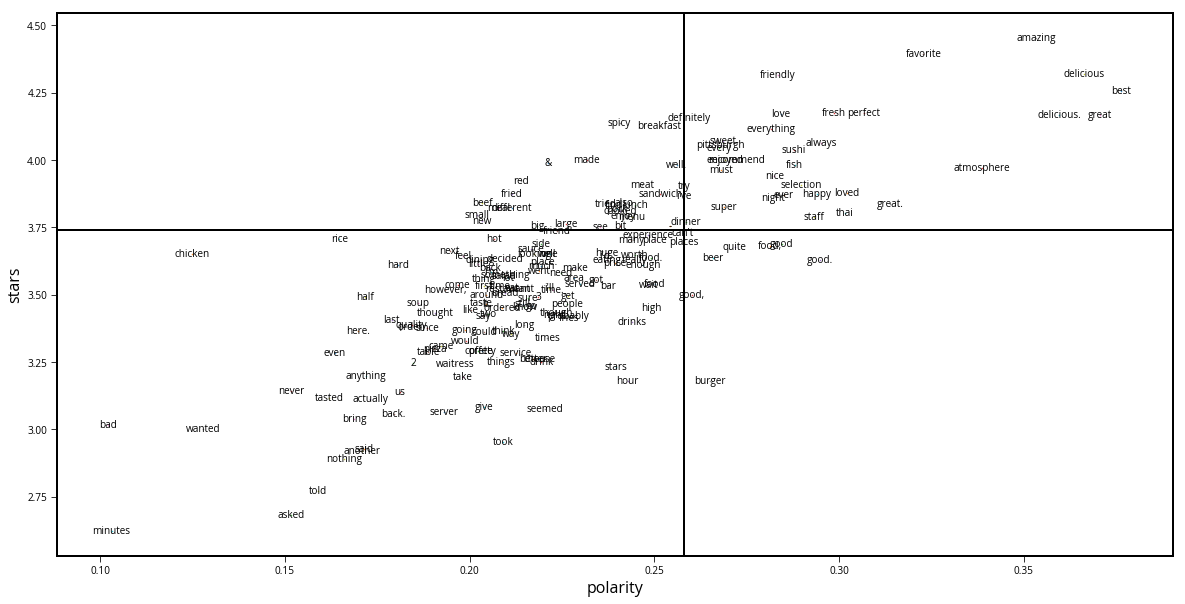

In [38]:
# use iterrows to loop over each row
for i, row in df.iterrows():
    
    # scatter plot
    plt.scatter(row['polarity'], row['stars'], marker='.', s=1)
    
    # add the text label
    plt.text(row['polarity'], row['stars'], i, ha='center', va='center')
    
# avg polarity
avg_polarity = reviews['polarity'].mean()
# avg stars 
avg_stars = reviews['stars'].mean()

# get the current axes
ax = plt.gca()

# add labels
ax.set_xlabel("polarity", fontsize=16)
ax.set_ylabel("stars", fontsize=16)

# add horizontal and vertical lines
ax.axhline(y=avg_stars, color='black', linewidth=2)
ax.axvline(x=avg_polarity, color='black', linewidth=2)

# set the size of the figure
ax.figure.set_size_inches(20,10)

## 2. Correlating restaurant data and household income

In this part, we'll use the census API to download household income data and overlay restaurant locations.

### 2.1 Query the Census API

Use the `census_area` package to download total household income by census tract (with tract geometries) from the 2017 ACS data set. You can identify the proper variable name from:

https://api.census.gov/data/2017/acs/acs5/variables.html

**Hints**

The FIPS codes for the various cities are: 

- Pittsburgh
    - PA code: '42'
    - City code: '61000'
- Cleveland
    - OH code: '39'
    - City code: '16000'
- Charlotte
    - NC code: '37'
    - City code: '12000'

In [40]:
from census_area import Census
import os

In [41]:
# I have stored my API key as an environment variable on my computer
# you should use your own API key here
api_key = os.environ['CENSUS_API_KEY']

In [42]:
# initialize the Census object
c = Census(key=api_key)

In [43]:
# FIPS codes
pa_code = '42'
city_code = '61000'

In [44]:
# variables we want: see https://api.census.gov/data/2017/acs/acs5/variables.html
variables = ['NAME', 'B19013_001E']

In [45]:
# get the data by census tract
features = c.acs5.state_place_tract(variables, pa_code, city_code, year=2017, return_geometry=True)

### 2.2 Convert the GeoJSON features to a GeoDataFrame

Be sure to use the proper CRS for census data.

In [47]:
import geopandas as gpd

In [48]:
# initialize the GeoDataFrame
crs = {'init':'epsg:4269'}
income = gpd.GeoDataFrame.from_features(features, crs=crs)

In [49]:
# select only where the income is greater than zero
income = income.loc[income['B19013_001E'] > 0].to_crs(epsg=3857)

## 2.3 Plot a choropleth map of the household income

Use the built-in `geopandas` `plot()` function. 

Be sure to convert to a reasonable CRS first!

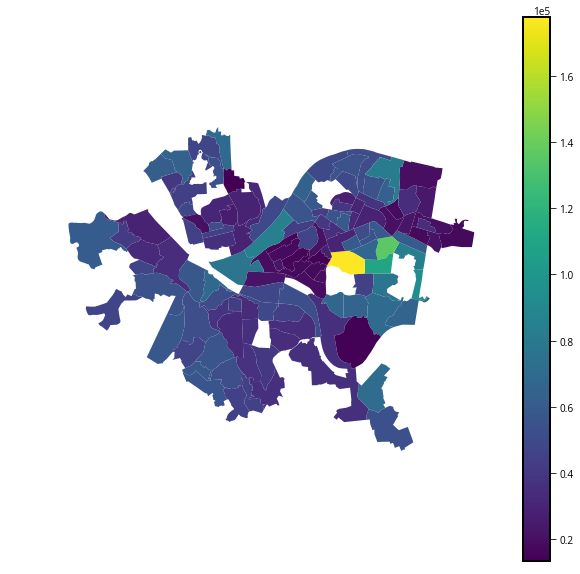

In [52]:
ax = income.to_crs(epsg=3857).plot(column='B19013_001E', legend=True)

ax.set_axis_off()
ax.set_aspect('equal')
ax.figure.set_size_inches((10,10))

## 2.4 Load the restaurants data

Use the `latitude` and `longitude` columns to create a GeoDataFrame after loading the JSON data.

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [53]:
restaurants = pd.read_json('./data/restaurants_pittsburgh.json.gz', orient='records', lines=True)

In [54]:
from shapely.geometry import Point

In [55]:
# convert from a DataFrame to a GeoDataFrame
restaurants['geometry'] = restaurants.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
restaurants = gpd.GeoDataFrame(restaurants, crs={'init':'epsg:4326'})

## 2.5 Overlay restaurants on the income map

Overlay the restaurants and color the points according to the 'stars' column. 

You can use the 'coolwarm' color map: blue points will have below-average reviews and red points will have above-average stars. 

**Hint**

You can use the `.geometry.total_bounds` attribute to get the axes limits of the city's census tracts. 

```python
[xmin, ymin, xmax, ymax] = income.geometry.total_bounds
```

You can then use these limits to set the matplotlib plot limits accordingly.

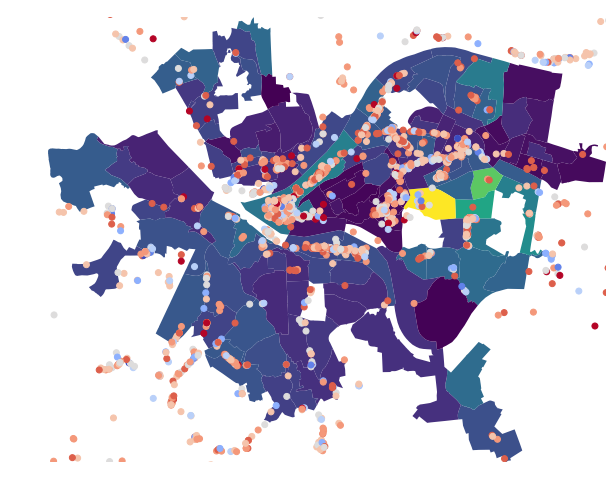

In [56]:
# get the extent of the polygons
extent = income.to_crs(epsg=3857).total_bounds

# plot
ax = income.to_crs(epsg=3857).plot(column='B19013_001E')
restaurants.to_crs(epsg=3857).plot(ax=ax, column='stars', alpha=1, cmap='coolwarm')

# set the limits
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

# format
ax.set_axis_off()
ax.set_aspect('equal')

ax.figure.set_size_inches(10,10)

## 2.6 Comparing polarity vs. stars geographically

- Merge the restaurants GeoDataFrame with the DataFrame with the 'polarity' column for each review. 
- Make a side-by-side plot with two columns: one subplot shows hex bins giving the polarity of the restaurant review and the other shows hex bins giving the number of stars

As we saw in Section 1, you should see strong correlation between the two subplots. 

**Hints**
- The 'business_id' column should be present in both the data frames holding review data and restaurant data.
- See the `plt.subplots()` function for creating a figure with 2 subplots.


In [58]:
restaurants.head()

,business_id,latitude,longitude,name,review_count,stars,geometry
0,1RHY4K3BD22FK7Cfftn8Mg,40.496177,-80.246011,Marathon Diner,35,4.0,POINT (-80.24601123639999 40.4961769456)
1,dQj5DLZjeDK3KFysh1SYOQ,40.465694,-79.949324,Apteka,242,4.5,POINT (-79.9493238 40.4656937)
2,v-scZMU6jhnmV955RSzGJw,40.441062,-80.002126,No. 1 Sushi Sushi,106,4.5,POINT (-80.002126 40.441062)
3,t-6tdxRaz7s9a0sf94Tguw,40.462345,-79.924165,Impressionz,29,4.5,POINT (-79.92416515950001 40.4623454064)
4,5WMIvoMx3l1vn1uJ3HZB6Q,40.442863,-79.996412,Subway,3,3.0,POINT (-79.99641200000001 40.4428627)


In [59]:
reviews.head()

,business_id,review_id,stars,text,formatted_text,polarity,subjectivity
0,eU_713ec6fTGNO4BegRaww,fdiNeiN_hoCxCMy2wTRW9g,4,I'll be the first to admit that I was not exci...,"[i'll, first, admit, excited, going, la, tavol...",0.245505,0.609437
1,FxLfqxdYPA6Z85PFKaqLrg,Z7wgXp98wYB57QdRY3HQ3w,4,Wow. So surprised at the one and two star revi...,"[wow., surprised, one, two, star, reviews!, st...",0.597787,0.818427
2,9nTF596jDvBBia2EXXiOOg,1daGBpea0sleayFeeXuoYw,1,"if i can give this place no stars i would, i o...","[give, place, stars, would,, hot, pot, though,...",0.053869,0.664137
3,sMzNLdhJZGzYirIWt-fMAg,RLbWoIri29BcQ8yjzsvQLQ,5,This place epitomizes the rumored transformati...,"[place, epitomizes, rumored, transformation, p...",0.266667,0.416667
4,hcFSc0OHgZJybnjQBrL_8Q,vAckaF8n0KKJeqHOnb1ayw,4,Here's why I don't write reviews for Chinese r...,"[here's, write, reviews, chinese, restaurants:...",0.227083,0.557576


In [71]:
joined = pd.merge(restaurants, reviews, on='business_id')

In [75]:
joined.head()

,business_id,latitude,longitude,name,review_count,stars_x,geometry,review_id,stars_y,text,formatted_text,polarity,subjectivity
0,1RHY4K3BD22FK7Cfftn8Mg,40.496177,-80.246011,Marathon Diner,35,4.0,POINT (-80.24601123639999 40.4961769456),PaPQzyr6chg_eo_u4mw0Dw,5,"Marathon Diner may not look fancy, but I had t...","[marathon, diner, may, look, fancy,, best, air...",0.311607,0.590516
1,1RHY4K3BD22FK7Cfftn8Mg,40.496177,-80.246011,Marathon Diner,35,4.0,POINT (-80.24601123639999 40.4961769456),hpV7n-LmphR56l3YKVshiw,2,What a ripoff. For a $13 salad all you get is ...,"[ripoff., $13, salad, get, iceberg, lettuce,, ...",0.133333,0.516667
2,1RHY4K3BD22FK7Cfftn8Mg,40.496177,-80.246011,Marathon Diner,35,4.0,POINT (-80.24601123639999 40.4961769456),MPmKK0e8zuOjjae2hr-YJg,5,This experience was a joy. The food was great....,"[experience, joy., food, great., service, grea...",0.428571,0.478571
3,1RHY4K3BD22FK7Cfftn8Mg,40.496177,-80.246011,Marathon Diner,35,4.0,POINT (-80.24601123639999 40.4961769456),EJDXWWLfY3bWI-b4K1Bnxw,1,The one at the airport is just ... bad the ser...,"[one, airport, ..., bad, servers, bored, attit...",-0.450000,0.688889
4,1RHY4K3BD22FK7Cfftn8Mg,40.496177,-80.246011,Marathon Diner,35,4.0,POINT (-80.24601123639999 40.4961769456),J9569hRV3zEWoYHosHZ6AA,5,Had an early flight and wife and I were hungr...,"[early, flight, wife, hungry., noticed, marath...",0.366667,0.350000


In [67]:
import cartopy.crs as ccrs

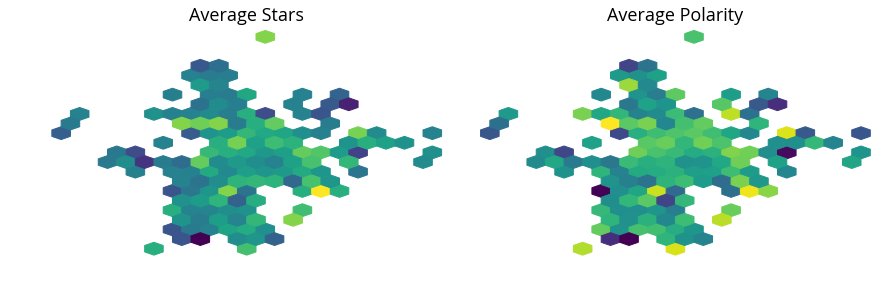

In [92]:
# initialize two figures
fig, axs = plt.subplots(ncols=2, figsize=(15, 10), gridspec_kw={'wspace':0.05})

# plot both columns
columns = ['stars_x', 'polarity']
titles = ['Average Stars', "Average Polarity"]
for i, col in enumerate(columns):
    
    # make the hexbin plot
    ax = axs[i]
    ax.hexbin(x=joined.geometry.x, y=joined.geometry.y, C=joined[col], 
            gridsize=20, cmap='viridis')
    
    # set background color
    viridis = plt.get_cmap('viridis')
    ax.set_facecolor(viridis(0))
    
    # format
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=18)